## Predicción e Interpretabilidad de Resultados de Citas Médicas (XAI + Fairness)

**Autores:**
- Fernando Viteri  
- Adrian Ponguillo  
- Andres Moreta  
- Antonio Insuasti  

**Fecha:** Febrero 2026  

**Resumen:**  
Este notebook desarrolla un modelo de clasificación para predecir el estado final de las citas médicas (**`ESTAFINAL`**) a partir de variables del paciente y del contexto de la cita. El flujo cubre exploración y validación de datos, ingeniería de variables temporales, entrenamiento y evaluación del modelo base con métricas robustas para clases desbalanceadas, y un análisis de **explicabilidad** mediante **SHAP** y **LIME** (global y local). Finalmente, se realiza una **auditoría de sesgos** por subgrupos y una mitigación inicial para analizar el trade-off entre desempeño y equidad, cerrando con recomendaciones técnicas y éticas para un uso responsable del sistema.

### Entorno de trabajo

In [39]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from IPython.display import HTML, Markdown, display

from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    RocCurveDisplay,
    accuracy_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
)
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import shap
from lime.lime_tabular import LimeTabularExplainer
from tqdm.auto import tqdm

### Configuración global y utilidades de exportación

In [40]:
RANDOM_STATE = 42
# None -> usa todo X_test para SHAP; un entero limita la muestra para acelerar XAI
SHAP_SAMPLE_SIZE = 300
RESULTS_DIR = Path('../resultados')
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

plot_counter = 1


def _next_results_file(suffix, extension='png'):
    global plot_counter
    safe_suffix = ''.join(ch if (ch.isalnum() or ch == '_') else '_' for ch in suffix.lower()).strip('_')
    path = RESULTS_DIR / f'{plot_counter}_{safe_suffix}.{extension}'
    plot_counter += 1
    return path


def save_current_figure(suffix, fig=None):
    path = _next_results_file(suffix, 'png')
    (fig or plt.gcf()).savefig(path, bbox_inches='tight')
    print(f'Grafico exportado: {path}')
    return path


sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

def fit_random_forest_with_progress(X_train_local, y_train_local, *, n_estimators=200, desc='Entrenando Random Forest', **rf_kwargs):
    """Entrena un RandomForest incremental con barra de progreso visible en notebook."""
    if n_estimators < 1:
        raise ValueError('n_estimators debe ser >= 1')

    # sklearn advierte contra warm_start con class_weight='balanced'.
    # Calculamos los pesos una sola vez sobre TODO y_train_local y pasamos un dict fijo.
    class_weight_value = rf_kwargs.get('class_weight')
    if class_weight_value in {'balanced', 'balanced_subsample'}:
        y_arr = np.asarray(y_train_local)
        classes = np.unique(y_arr)
        weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_arr)
        rf_kwargs = dict(rf_kwargs)
        rf_kwargs['class_weight'] = {cls: float(w) for cls, w in zip(classes, weights)}

    rf_model = RandomForestClassifier(
        n_estimators=1,
        warm_start=True,
        **rf_kwargs,
    )
    for n_trees in tqdm(range(1, n_estimators + 1), total=n_estimators, desc=desc, ascii=True):
        rf_model.set_params(n_estimators=n_trees)
        rf_model.fit(X_train_local, y_train_local)
    return rf_model

## 1. Carga y comprensión del dataset

En esta sección se carga el dataset, se revisa su estructura general y se conserva una copia cruda (`df_raw`) para auditorías posteriores (calidad de datos y sesgos).


### Carga inicial del dataset

In [41]:
df = pd.read_excel('../Dataset/citaschallenge.xlsx')
df_raw = df.copy()

print(f'Filas, columnas: {df.shape}')
print('\nTipos de datos iniciales:')
print(df.dtypes)

print('\nPrimeras filas:')
display(df.head())

print('\nResumen estadistico (incluye categoricas):')
display(df.describe(include='all').T)

Filas, columnas: (67650, 7)

Tipos de datos iniciales:
GENERO                        str
EDAD                      float64
ESPECIALIDAD                  str
TIPO_AFILIACION               str
FECHA_CITA         datetime64[us]
id                          int64
ESTAFINAL                   int64
dtype: object

Primeras filas:


,GENERO,EDAD,ESPECIALIDAD,TIPO_AFILIACION,FECHA_CITA,id,ESTAFINAL
0,FEMENINO,41.0,ORTODONCIA,GOLD,2013-07-02 06:30:00,9373,3
1,FEMENINO,49.0,TERAPIA OCUPACIONAL,SILVER,2013-07-02 06:30:00,62884,2
2,FEMENINO,41.0,FISIOTERAPIA,GOLD,2013-07-02 06:30:00,72568,2
3,FEMENINO,49.0,FISIOTERAPIA,GOLD,2013-07-02 06:50:00,5733,1
4,FEMENINO,36.0,RADIOLOGIA,GOLD,2013-07-02 06:50:00,22397,3



Resumen estadistico (incluye categoricas):


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
GENERO,67650,2,MASCULINO,34346,NaN,NaN,NaN,NaN,NaN,NaN,NaN
EDAD,67650.0,NaN,NaN,NaN,38.699956,0.0,29.0,38.0,49.0,96.0,14.525066
ESPECIALIDAD,67650,32,FISIOTERAPIA,15136,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TIPO_AFILIACION,67650,3,SILVER,36396,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FECHA_CITA,67650,NaN,NaN,NaN,2013-09-10 15:06:53.286917,2013-07-02 06:30:00,2013-08-05 14:00:00,2013-09-10 14:45:00,2013-10-16 15:33:45,2013-11-21 18:40:00,NaN
id,67650.0,NaN,NaN,NaN,43890.418182,1.0,22202.25,43809.5,65567.75,87877.0,25295.366353
ESTAFINAL,67650.0,NaN,NaN,NaN,2.010126,1.0,2.0,2.0,2.0,3.0,0.603249


## 2. Calidad de datos y analisis exploratorio

Se revisan nulos, duplicados, distribucion de clases, posibles outliers de edad y distribuciones relevantes para sustentar el modelado.


### Calidad de datos: nulos, duplicados, rango de fechas y distribuciones

Valores nulos por columna:
GENERO             0
EDAD               0
ESPECIALIDAD       0
TIPO_AFILIACION    0
FECHA_CITA         0
id                 0
ESTAFINAL          0
dtype: int64

Cantidad de filas duplicadas: 0

Rango FECHA_CITA: 2013-07-02 06:30:00 -> 2013-11-21 18:40:00
Registros con FECHA_CITA invalida tras parseo: 0

Distribucion de ESTAFINAL:


,conteo,porcentaje
ESTAFINAL,,
1,11970,17.69
2,43025,63.60
3,12655,18.71


Grafico exportado: ../resultados/1_calidad_distribucion_clases_estafinal.png


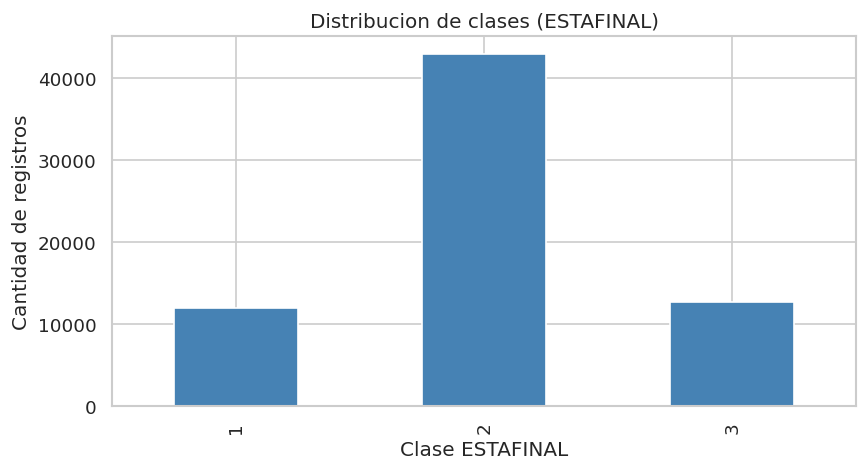


EDAD - IQR: Q1=29.00, Q3=49.00, limite inferior=-1.00, limite superior=79.00
Cantidad de posibles outliers de EDAD (IQR): 393
Grafico exportado: ../resultados/2_calidad_boxplot_edad_por_estafinal.png


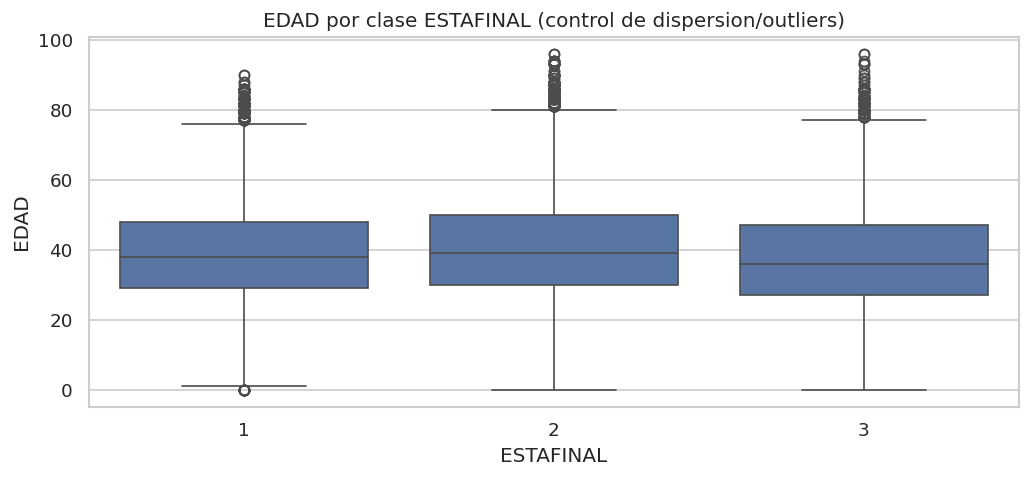


Top 10 especialidades por frecuencia:


,conteo
ESPECIALIDAD,
FISIOTERAPIA,15136
TERAPIA OCUPACIONAL,14546
MEDICINA GENERAL,6756
ORTOPEDIA Y TRAUMATOLOGIA,5306
CIRUGIA DE LA MANO,3859
ODONTOLOGIA,3484
FISIATRIA,2428
OPTOMETRIA,1543
DERMATOLOGIA,1432


Grafico exportado: ../resultados/3_calidad_top_especialidades_frecuencia.png


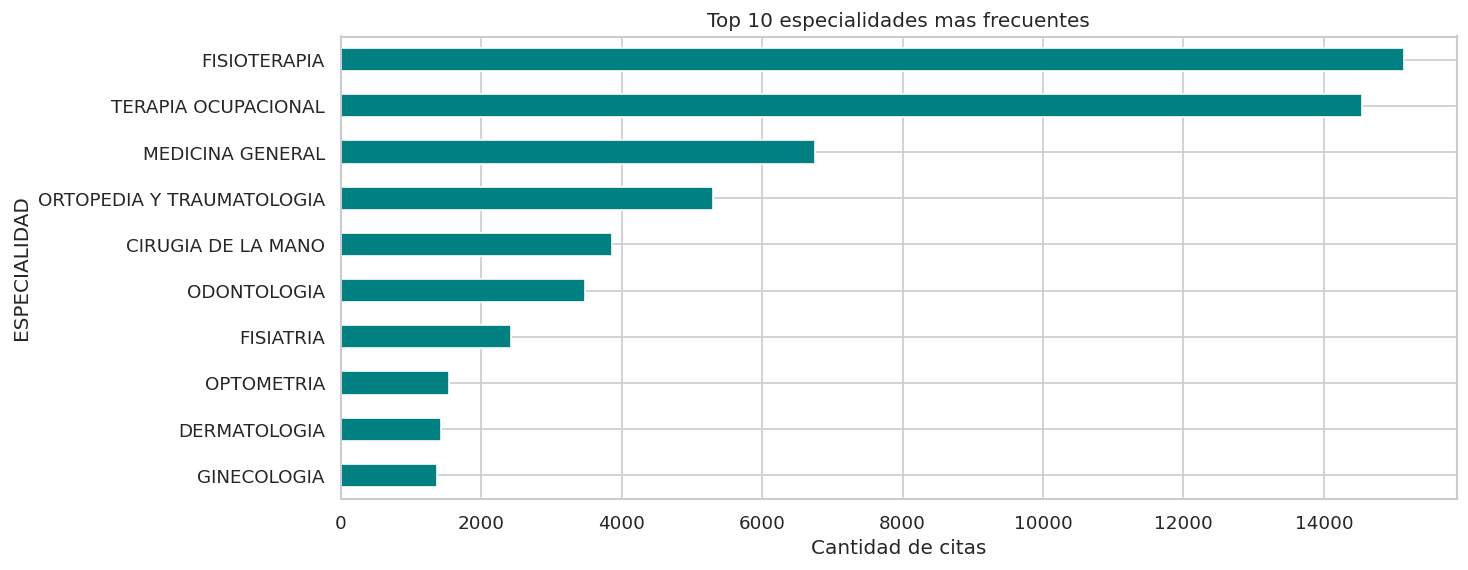

Grafico exportado: ../resultados/4_calidad_citas_por_mes.png


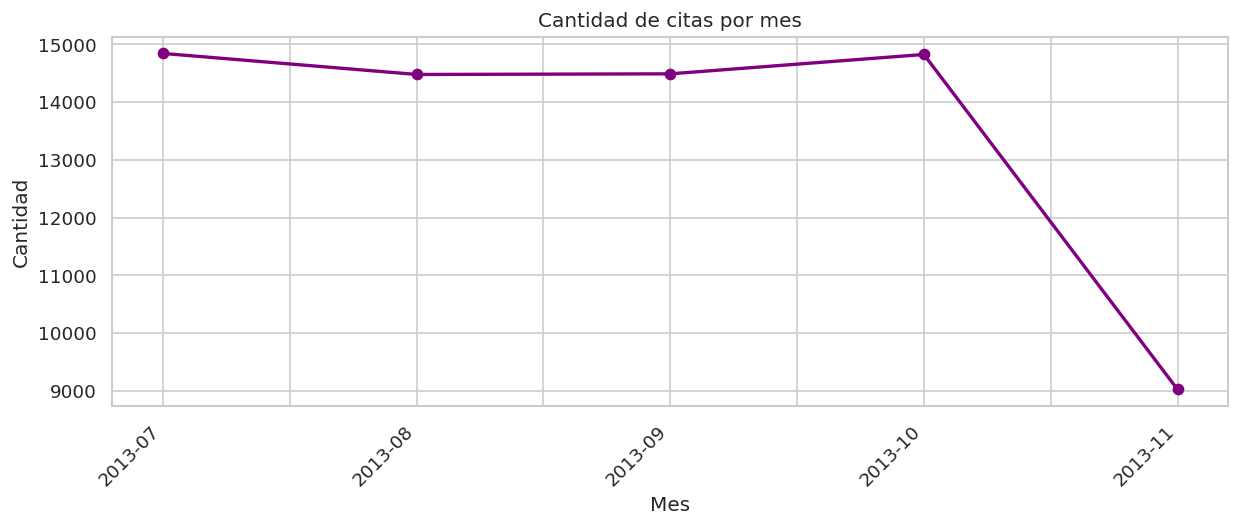

Grafico exportado: ../resultados/5_eda_distribucion_genero_tipo_afiliacion.png


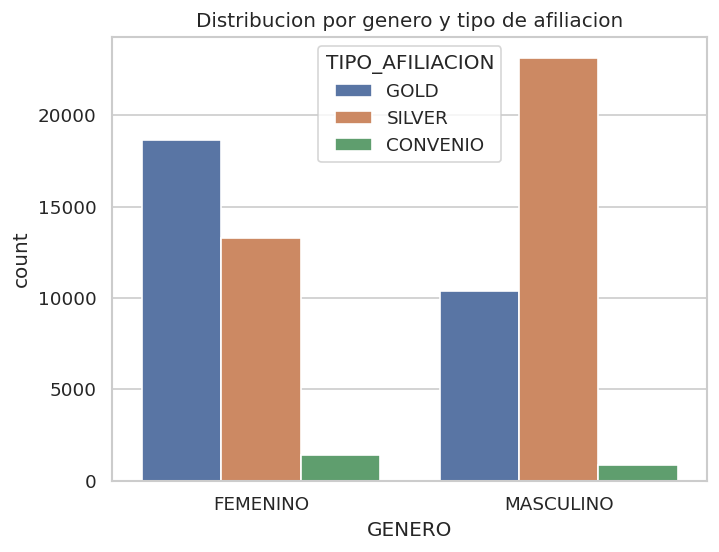

Grafico exportado: ../resultados/6_eda_distribucion_edad_tipo_afiliacion.png


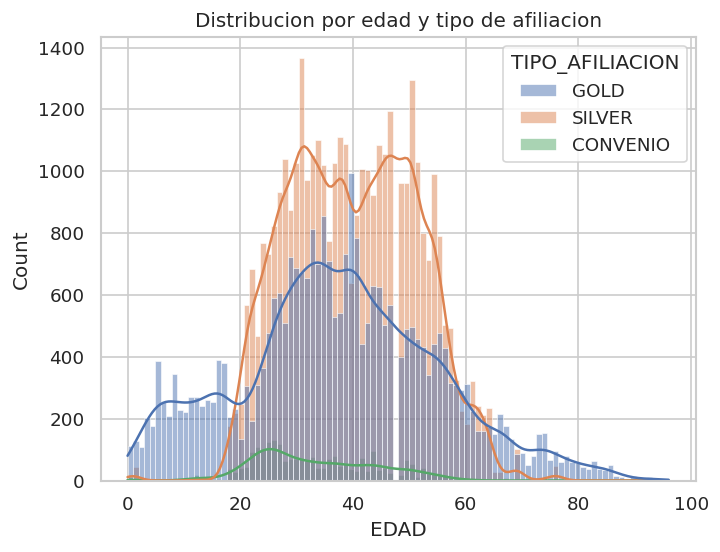


Tasa de afiliacion GOLD por genero (%):
GENERO
FEMENINO     55.92
MASCULINO    30.17
dtype: float64


In [42]:
print('Valores nulos por columna:')
print(df.isnull().sum())

print(f'\nCantidad de filas duplicadas: {df.duplicated().sum()}')

# Aseguramos formato datetime para auditoria temporal
df['FECHA_CITA'] = pd.to_datetime(df['FECHA_CITA'], errors='coerce')
print(f"\nRango FECHA_CITA: {df['FECHA_CITA'].min()} -> {df['FECHA_CITA'].max()}")
print(f"Registros con FECHA_CITA invalida tras parseo: {df['FECHA_CITA'].isna().sum()}")

# Distribucion del objetivo
class_counts = df['ESTAFINAL'].value_counts().sort_index()
class_pct = df['ESTAFINAL'].value_counts(normalize=True).sort_index().mul(100).round(2)
class_summary = pd.DataFrame({'conteo': class_counts, 'porcentaje': class_pct})
print('\nDistribucion de ESTAFINAL:')
display(class_summary)

plt.figure(figsize=(8, 4))
class_counts.plot(kind='bar', color='steelblue', title='Distribucion de clases (ESTAFINAL)')
plt.xlabel('Clase ESTAFINAL')
plt.ylabel('Cantidad de registros')
save_current_figure('calidad_distribucion_clases_estafinal')
plt.show()
plt.close()

# Outliers de EDAD por regla IQR
edad_q1 = df['EDAD'].quantile(0.25)
edad_q3 = df['EDAD'].quantile(0.75)
edad_iqr = edad_q3 - edad_q1
edad_low = edad_q1 - 1.5 * edad_iqr
edad_high = edad_q3 + 1.5 * edad_iqr
edad_outliers = df[(df['EDAD'] < edad_low) | (df['EDAD'] > edad_high)]
print(f'\nEDAD - IQR: Q1={edad_q1:.2f}, Q3={edad_q3:.2f}, limite inferior={edad_low:.2f}, limite superior={edad_high:.2f}')
print(f'Cantidad de posibles outliers de EDAD (IQR): {len(edad_outliers)}')

plt.figure(figsize=(10, 4))
sns.boxplot(data=df, x='ESTAFINAL', y='EDAD')
plt.title('EDAD por clase ESTAFINAL (control de dispersion/outliers)')
save_current_figure('calidad_boxplot_edad_por_estafinal')
plt.show()
plt.close()

# Top especialidades
especialidad_top = df['ESPECIALIDAD'].value_counts().head(10)
print('\nTop 10 especialidades por frecuencia:')
display(especialidad_top.to_frame('conteo'))

plt.figure(figsize=(12, 5))
especialidad_top.sort_values().plot(kind='barh', color='teal', title='Top 10 especialidades mas frecuentes')
plt.xlabel('Cantidad de citas')
save_current_figure('calidad_top_especialidades_frecuencia')
plt.show()
plt.close()

# Temporalidad de citas (mes)
citas_por_mes = df['FECHA_CITA'].dt.to_period('M').astype(str).value_counts().sort_index()
plt.figure(figsize=(12, 4))
citas_por_mes.plot(marker='o', linewidth=2, color='purple', title='Cantidad de citas por mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')
save_current_figure('calidad_citas_por_mes')
plt.show()
plt.close()

# EDA original solicitado
sns.countplot(data=df, x='GENERO', hue='TIPO_AFILIACION')
plt.title('Distribucion por genero y tipo de afiliacion')
save_current_figure('eda_distribucion_genero_tipo_afiliacion')
plt.show()
plt.close()

sns.histplot(data=df, x='EDAD', hue='TIPO_AFILIACION', kde=True)
plt.title('Distribucion por edad y tipo de afiliacion')
save_current_figure('eda_distribucion_edad_tipo_afiliacion')
plt.show()
plt.close()

gold_by_gender = df[df['TIPO_AFILIACION'].astype(str).str.upper() == 'GOLD'].groupby('GENERO').size()
total_by_gender = df.groupby('GENERO').size()
tasa_gold_by_gender = (gold_by_gender / total_by_gender * 100).round(2)
print('\nTasa de afiliacion GOLD por genero (%):')
print(tasa_gold_by_gender)

## 3. Limpieza, transformación y partición de datos

Se limpian variables categóricas, se crean variables temporales y se divide el conjunto con estratificación por la variable objetivo para una evaluación mas estable.


### Limpieza y preprocesamiento para modelado

Copias auxiliares para auditoria de sesgos (mantienen etiquetas originales)

In [43]:
df_model = df.copy()

# Mapeos categoricos
gender_map = {'FEMENINO': 0, 'MASCULINO': 1}
affiliation_map = {'CONVENIO': 1, 'SILVER': 2, 'GOLD': 3}

df_model['GENERO'] = df_model['GENERO'].astype(str).str.upper().map(gender_map)
df_model['TIPO_AFILIACION'] = df_model['TIPO_AFILIACION'].astype(str).str.upper().map(affiliation_map)

if df_model['GENERO'].isnull().any():
    faltantes = sorted(df.loc[df_model['GENERO'].isnull(), 'GENERO'].astype(str).unique())
    raise ValueError(f'Valores inesperados en GENERO tras mapeo: {faltantes}')

if df_model['TIPO_AFILIACION'].isnull().any():
    faltantes = sorted(df.loc[df_model['TIPO_AFILIACION'].isnull(), 'TIPO_AFILIACION'].astype(str).unique())
    raise ValueError(f'Valores inesperados en TIPO_AFILIACION tras mapeo: {faltantes}')

# Variables temporales
df_model['MES'] = df_model['FECHA_CITA'].dt.month
df_model['DIA_SEMANA'] = df_model['FECHA_CITA'].dt.dayofweek

# Codificacion de ESPECIALIDAD
label_encoder_especialidad = LabelEncoder()
df_model['ESPECIALIDAD_ENCODED'] = label_encoder_especialidad.fit_transform(df_model['ESPECIALIDAD'].astype(str))

# Tipos finales
df_model['GENERO'] = df_model['GENERO'].astype(int)
df_model['EDAD'] = df_model['EDAD'].astype(int)
df_model['TIPO_AFILIACION'] = df_model['TIPO_AFILIACION'].astype(int)
df_model['MES'] = df_model['MES'].astype(int)
df_model['DIA_SEMANA'] = df_model['DIA_SEMANA'].astype(int)

print('Tipos de datos luego de preprocesamiento:')
print(df_model.dtypes)

# Definicion de features y target para modelo base
features = ['GENERO', 'EDAD', 'ESPECIALIDAD_ENCODED', 'TIPO_AFILIACION', 'MES', 'DIA_SEMANA']
sensitive_features = ['GENERO', 'TIPO_AFILIACION']
X = df_model[features].copy()
y = df_model['ESTAFINAL'].copy()

# Split estratificado para mayor estabilidad en clases
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y,
)

print(f'\nShapes -> X_train: {X_train.shape}, X_test: {X_test.shape}')
print('Distribucion de clases en train (%):')
print((y_train.value_counts(normalize=True).sort_index() * 100).round(2))
print('Distribucion de clases en test (%):')
print((y_test.value_counts(normalize=True).sort_index() * 100).round(2))

# Contexto original del test para auditorias posteriores (sesgos, interpretacion)
test_context = df_raw.loc[X_test.index, ['GENERO', 'EDAD', 'ESPECIALIDAD', 'TIPO_AFILIACION', 'FECHA_CITA']].copy()

Tipos de datos luego de preprocesamiento:
GENERO                           int64
EDAD                             int64
ESPECIALIDAD                       str
TIPO_AFILIACION                  int64
FECHA_CITA              datetime64[us]
id                               int64
ESTAFINAL                        int64
MES                              int64
DIA_SEMANA                       int64
ESPECIALIDAD_ENCODED             int64
dtype: object

Shapes -> X_train: (54120, 6), X_test: (13530, 6)
Distribucion de clases en train (%):
ESTAFINAL
1    17.69
2    63.60
3    18.71
Name: proportion, dtype: float64
Distribucion de clases en test (%):
ESTAFINAL
1    17.69
2    63.60
3    18.71
Name: proportion, dtype: float64


## 4. Modelo supervisado base (Random Forest) y evaluación

Se entrena un modelo supervisado (Random Forest) y se reportan métricas de holdout, matriz de confusión, curvas ROC multiclase y validación cruzada para estabilidad.


### Entrenamiento del modelo base y evaluación holdout

Entrenamiento modelo base (RF):   0%|          | 0/200 [00:00<?, ?it/s]

Metricas holdout (modelo base):


,metrica,valor
0,accuracy,0.597635
1,f1_macro,0.415984
2,balanced_accuracy,0.412809



Classification report (holdout):
              precision    recall  f1-score   support

           1       0.25      0.15      0.19      2394
           2       0.68      0.82      0.75      8605
           3       0.38      0.27      0.31      2531

    accuracy                           0.60     13530
   macro avg       0.44      0.41      0.42     13530
weighted avg       0.55      0.60      0.57     13530

Grafico exportado: ../resultados/7_modelo_importancia_caracteristicas_random_forest.png


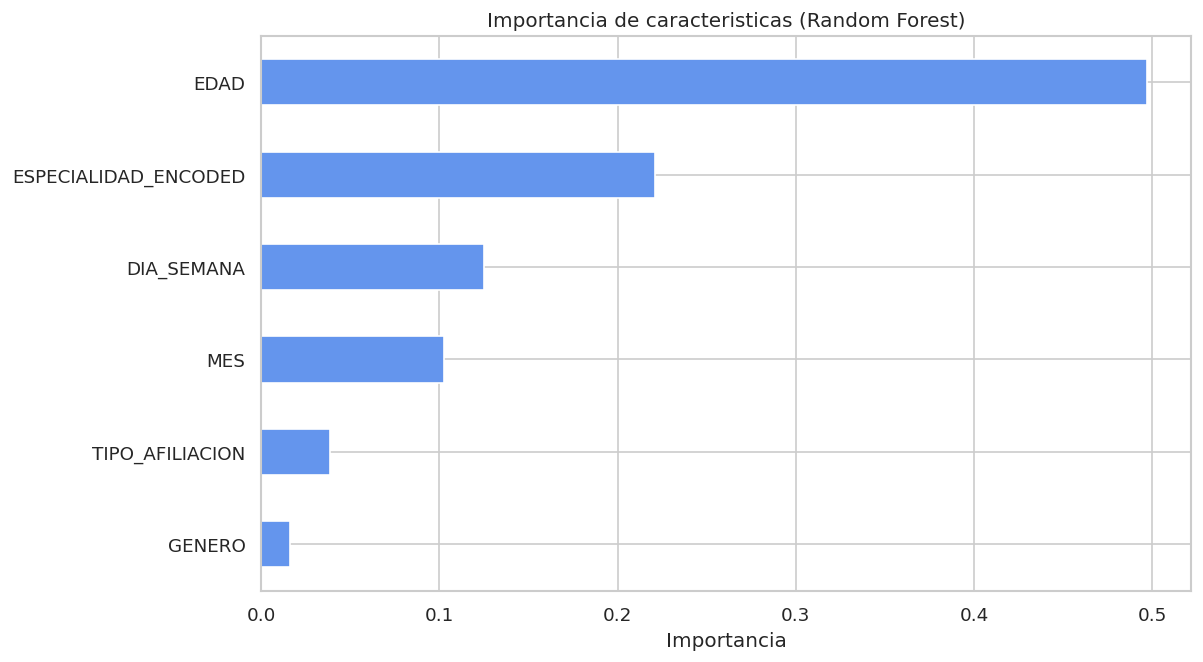

Grafico exportado: ../resultados/8_modelo_matriz_confusion_base.png


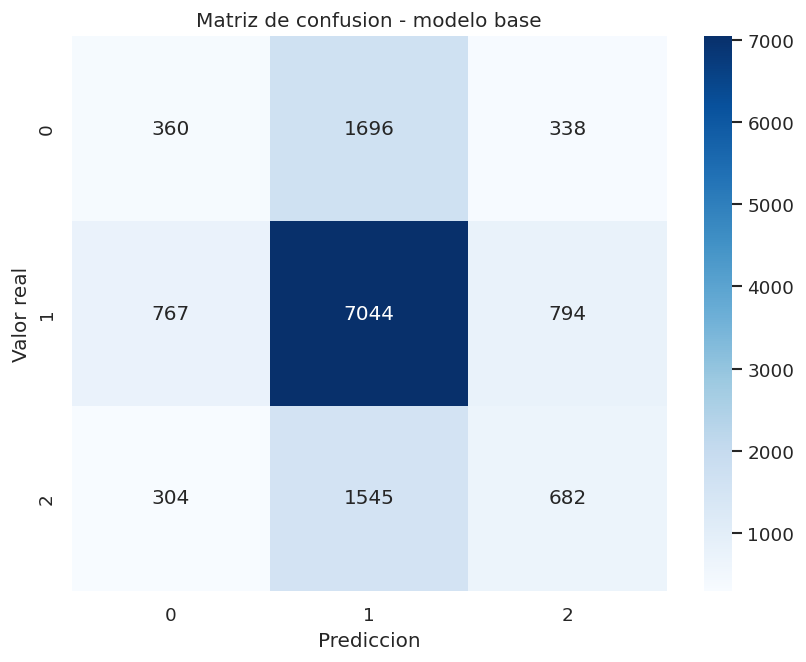

Grafico exportado: ../resultados/9_modelo_curvas_roc_multiclase_ovr_base.png


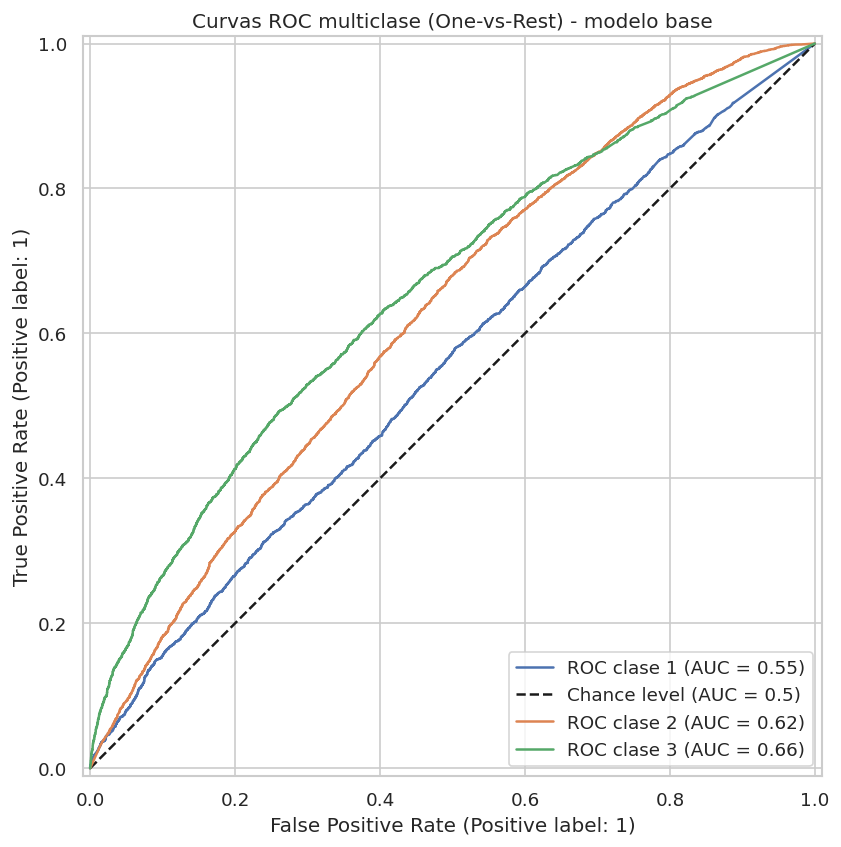

Grafico exportado: ../resultados/10_modelo_metricas_holdout_base.png


/tmp/ipykernel_42915/3990638707.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=baseline_metrics_df, x='metrica', y='valor', palette='Set2')


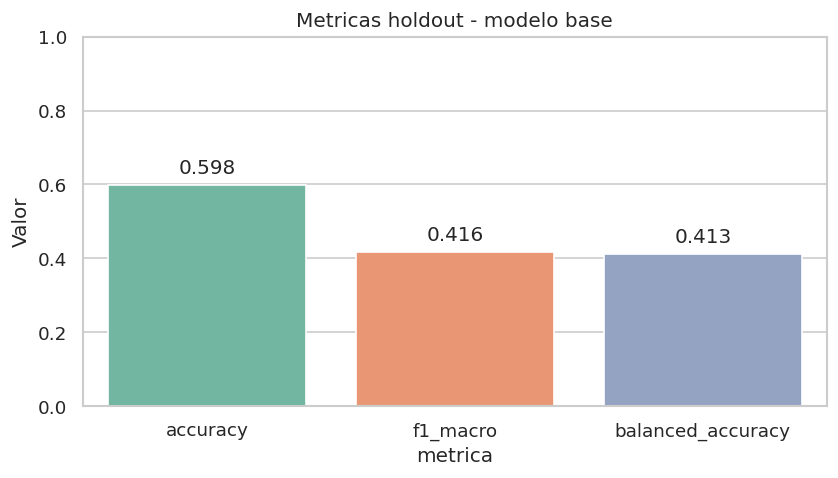

In [44]:
model = fit_random_forest_with_progress(
    X_train,
    y_train,
    n_estimators=200,
    desc='Entrenamiento modelo base (RF)',
    random_state=RANDOM_STATE,
    n_jobs=-1,
)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)
classes = sorted(y_test.unique())

baseline_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'f1_macro': f1_score(y_test, y_pred, average='macro', zero_division=0),
    'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
}

baseline_metrics_df = pd.DataFrame(
    {'metrica': list(baseline_metrics.keys()), 'valor': list(baseline_metrics.values())}
)
print('Metricas holdout (modelo base):')
display(baseline_metrics_df)

print('\nClassification report (holdout):')
print(classification_report(y_test, y_pred, zero_division=0))

# Importancia de variables del modelo
feature_importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=True)
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='barh', color='cornflowerblue', title='Importancia de caracteristicas (Random Forest)')
plt.xlabel('Importancia')
save_current_figure('modelo_importancia_caracteristicas_random_forest')
plt.show()
plt.close()

# Matriz de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Prediccion')
plt.ylabel('Valor real')
plt.title('Matriz de confusion - modelo base')
save_current_figure('modelo_matriz_confusion_base')
plt.show()
plt.close()

# Curvas ROC OVR multiclase
plt.figure(figsize=(10, 8))
for i, class_id in enumerate(classes):
    y_test_binary = (y_test == class_id)
    RocCurveDisplay.from_predictions(
        y_test_binary,
        y_pred_proba[:, i],
        name=f'ROC clase {class_id}',
        ax=plt.gca(),
        plot_chance_level=(i == 0),
    )
plt.title('Curvas ROC multiclase (One-vs-Rest) - modelo base')
save_current_figure('modelo_curvas_roc_multiclase_ovr_base')
plt.show()
plt.close()

# Grafico resumen de metricas holdout
plt.figure(figsize=(8, 4))
sns.barplot(data=baseline_metrics_df, x='metrica', y='valor', palette='Set2')
plt.ylim(0, 1)
plt.title('Metricas holdout - modelo base')
plt.ylabel('Valor')
for idx, row in baseline_metrics_df.reset_index(drop=True).iterrows():
    plt.text(idx, row['valor'] + 0.02, f"{row['valor']:.3f}", ha='center', va='bottom')
save_current_figure('modelo_metricas_holdout_base')
plt.show()
plt.close()

### Validación cruzada (estabilidad del modelo)

Validacion cruzada (folds):   0%|          | 0/5 [00:00<?, ?it/s]

Metricas por fold (validacion cruzada 5-fold):


,fold,accuracy,f1_macro,balanced_accuracy
0,1,0.599630,0.413422,0.410876
1,2,0.602661,0.423264,0.418371
2,3,0.603991,0.418819,0.415616
3,4,0.596083,0.413706,0.410624
4,5,0.600665,0.420081,0.416576


Resumen validacion cruzada (5-fold):


,metrica,media,desv_std
0,accuracy,0.600606,0.002724
1,f1_macro,0.417858,0.003795
2,balanced_accuracy,0.414412,0.003120


Grafico exportado: ../resultados/11_modelo_base_validacion_cruzada_resumen.png


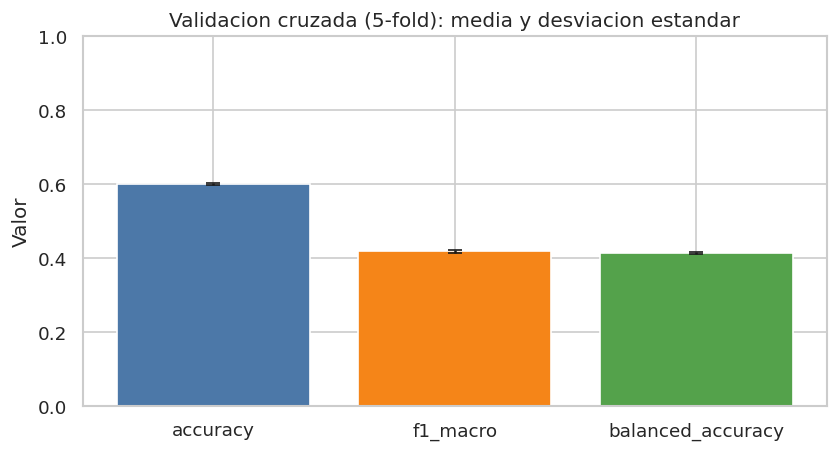

In [45]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
scoring = {
    'accuracy': 'accuracy',
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=0),
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
}

cv_estimator = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE, n_jobs=-1)
cv_rows = []

for fold_idx, (train_idx, val_idx) in enumerate(
    tqdm(cv.split(X, y), total=cv.get_n_splits(), desc='Validacion cruzada (folds)', ascii=True),
    start=1,
):
    X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
    y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

    fold_model = clone(cv_estimator)
    fold_model.fit(X_fold_train, y_fold_train)
    y_fold_pred = fold_model.predict(X_fold_val)

    cv_rows.append({
        'fold': fold_idx,
        'accuracy': accuracy_score(y_fold_val, y_fold_pred),
        'f1_macro': f1_score(y_fold_val, y_fold_pred, average='macro', zero_division=0),
        'balanced_accuracy': balanced_accuracy_score(y_fold_val, y_fold_pred),
    })

cv_folds_df = pd.DataFrame(cv_rows)
cv_summary_df = pd.DataFrame({
    'metrica': ['accuracy', 'f1_macro', 'balanced_accuracy'],
    'media': [cv_folds_df['accuracy'].mean(), cv_folds_df['f1_macro'].mean(), cv_folds_df['balanced_accuracy'].mean()],
    'desv_std': [cv_folds_df['accuracy'].std(ddof=0), cv_folds_df['f1_macro'].std(ddof=0), cv_folds_df['balanced_accuracy'].std(ddof=0)],
})

print('Metricas por fold (validacion cruzada 5-fold):')
display(cv_folds_df)

print('Resumen validacion cruzada (5-fold):')
display(cv_summary_df)

plt.figure(figsize=(8, 4))
plt.bar(cv_summary_df['metrica'], cv_summary_df['media'], yerr=cv_summary_df['desv_std'], capsize=4, color=['#4C78A8', '#F58518', '#54A24B'])
plt.ylim(0, 1)
plt.title('Validacion cruzada (5-fold): media y desviacion estandar')
plt.ylabel('Valor')
save_current_figure('modelo_base_validacion_cruzada_resumen')
plt.show()
plt.close()


## 5. Explicabilidad del modelo (XAI): SHAP y LIME

Se aplican dos tecnicas XAI (SHAP y LIME) para cubrir explicabilidad global, local y comparación entre técnicas sobre ejemplos concretos.

**Nota:** el modelo se entrena con todo el conjunto de entrenamiento (`X_train`). Solo SHAP usa una muestra de hasta 300 registros de `X_test` para acelerar la visualización; esto no reduce el entrenamiento del modelo.

### SHAP: explicabilidad global y local del modelo base (target = ESTAFINAL)

Muestreo para acelerar SHAP sin perder representatividad visual.

**SHAP local (multiclase):** la explicación del ejemplo individual se calcula para la **clase predicha por el modelo** (no para una clase elegida arbitrariamente).

SHAP_SAMPLE_SIZE efectivo: 300 de 13530 registros de X_test
Top 10 SHAP global (mean abs):
ESPECIALIDAD_ENCODED    0.060785
TIPO_AFILIACION         0.058506
EDAD                    0.050660
MES                     0.035914
DIA_SEMANA              0.033963
GENERO                  0.028426
dtype: float64
Grafico exportado: ../resultados/12_xai_shap_importancia_global_estafinal.png


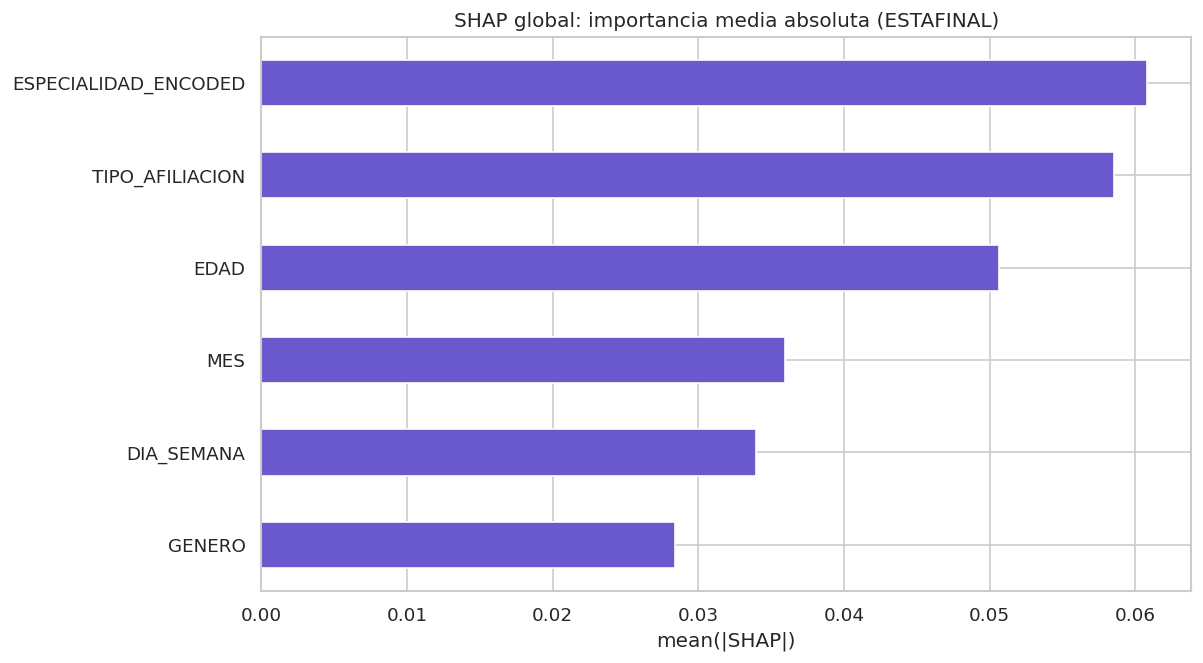

SHAP local interpreta la clase predicha del ejemplo: clase=2 (indice en model.classes_=1)

Prediccion del ejemplo SHAP local (indice original 8615): 2
La explicacion SHAP local mostrada corresponde a esa clase predicha.
Top SHAP local (ejemplo de comparacion):
TIPO_AFILIACION         0.095467
MES                     0.080626
ESPECIALIDAD_ENCODED    0.073842
EDAD                    0.039673
DIA_SEMANA              0.035560
GENERO                  0.015892
dtype: float64
Grafico exportado: ../resultados/13_xai_shap_local_force_estafinal_ejemplo_comparacion.png


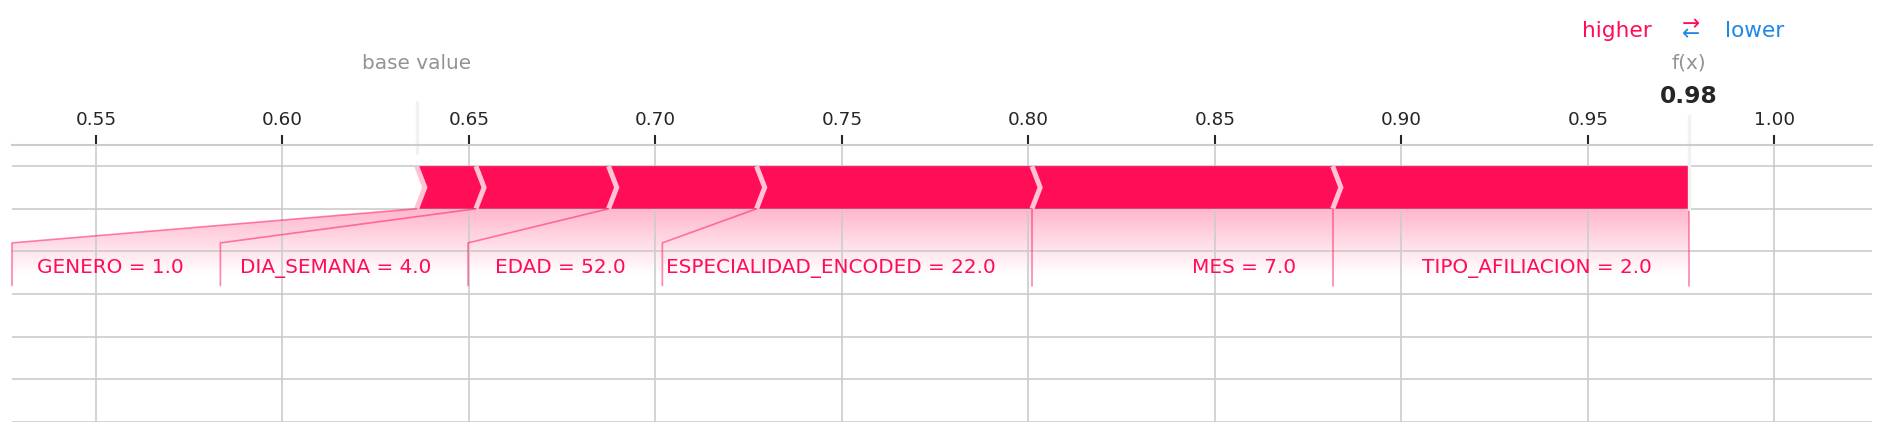

In [46]:
if SHAP_SAMPLE_SIZE is None:
    n_shap = len(X_test)
else:
    n_shap = min(int(SHAP_SAMPLE_SIZE), len(X_test))
    if n_shap < 1:
        raise ValueError('SHAP_SAMPLE_SIZE debe ser None o un entero >= 1')

X_shap_sample = X_test.sample(n=n_shap, random_state=RANDOM_STATE)
print(f'SHAP_SAMPLE_SIZE efectivo: {n_shap} de {len(X_test)} registros de X_test')

explainer_shap = shap.TreeExplainer(model)
shap_values = explainer_shap.shap_values(X_shap_sample)


def shap_global_mean_abs(shap_values_obj):
    if isinstance(shap_values_obj, list):
        return np.mean([np.abs(v).mean(axis=0) for v in shap_values_obj], axis=0)
    arr = np.array(shap_values_obj)
    if arr.ndim == 3:
        # Puede venir como (n_samples, n_features, n_classes)
        return np.abs(arr).mean(axis=(0, 2))
    return np.abs(arr).mean(axis=0)


def shap_local_for_class(shap_values_obj, row_position, pred_class, model_classes):
    if isinstance(shap_values_obj, list):
        class_idx_local = list(model_classes).index(pred_class)
        return shap_values_obj[class_idx_local][row_position], class_idx_local
    arr = np.array(shap_values_obj)
    if arr.ndim == 3:
        class_idx_local = list(model_classes).index(pred_class)
        return arr[row_position, :, class_idx_local], class_idx_local
    return arr[row_position, :], None


shap_importance = pd.Series(shap_global_mean_abs(shap_values), index=X_shap_sample.columns).sort_values(ascending=False)
print('Top 10 SHAP global (mean abs):')
print(shap_importance.head(10))

plt.figure(figsize=(10, 6))
shap_importance.head(15).sort_values().plot(kind='barh', color='slateblue', title='SHAP global: importancia media absoluta (ESTAFINAL)')
plt.xlabel('mean(|SHAP|)')
save_current_figure('xai_shap_importancia_global_estafinal')
plt.show()
plt.close()

# Explicacion local SHAP para 1 ejemplo del conjunto de test (mismo ejemplo que se usara en comparacion con LIME)
xai_example_pos = 0
xai_example_x = X_test.iloc[[xai_example_pos]].copy()
xai_example_index = X_test.index[xai_example_pos]
pred_xai_example = model.predict(xai_example_x)[0]
pred_xai_example_class_idx = list(model.classes_).index(pred_xai_example)
print(
    f'SHAP local interpreta la clase predicha del ejemplo: clase={pred_xai_example} '    f'(indice en model.classes_={pred_xai_example_class_idx})'
)

# SHAP local para el ejemplo de comparacion
shap_values_example = explainer_shap.shap_values(xai_example_x)
shap_local_values_example, shap_class_idx_example = shap_local_for_class(shap_values_example, 0, pred_xai_example, model.classes_)
shap_local_series_example = pd.Series(shap_local_values_example, index=X_test.columns)
shap_local_ranked_example = shap_local_series_example.reindex(shap_local_series_example.abs().sort_values(ascending=False).index)
print(f'\nPrediccion del ejemplo SHAP local (indice original {xai_example_index}): {pred_xai_example}')
print('La explicacion SHAP local mostrada corresponde a esa clase predicha.')
print('Top SHAP local (ejemplo de comparacion):')
print(shap_local_ranked_example.head(10))

# Render local (force plot en matplotlib) y guardado PNG
expected_value = explainer_shap.expected_value
if isinstance(expected_value, (list, np.ndarray)) and shap_class_idx_example is not None:
    expected_for_plot = np.array(expected_value)[shap_class_idx_example]
else:
    expected_for_plot = expected_value

try:
    shap.force_plot(expected_for_plot, shap_local_values_example, xai_example_x.iloc[0], matplotlib=True, show=False)
    fig = plt.gcf()
    save_current_figure('xai_shap_local_force_estafinal_ejemplo_comparacion', fig=fig)
    plt.show()
    plt.close(fig)
except Exception as e:
    print('No se pudo renderizar force_plot SHAP en este entorno:', repr(e))
    try:
        shap.plots._waterfall.waterfall_legacy(
            expected_value=expected_for_plot,
            shap_values=shap_local_values_example,
            feature_names=X_test.columns.tolist(),
            features=xai_example_x.iloc[0],
            max_display=15,
            show=False,
        )
        fig = plt.gcf()
        save_current_figure('xai_shap_local_waterfall_estafinal_ejemplo_comparacion', fig=fig)
        plt.show()
        plt.close(fig)
    except Exception as e2:
        print('Tampoco fue posible renderizar waterfall SHAP:', repr(e2))

### LIME: explicabilidad local del modelo base (1-2 ejemplos) y exportacion PNG

Grafico exportado: ../resultados/14_xai_lime_estafinal_ejemplo_pos_0.png


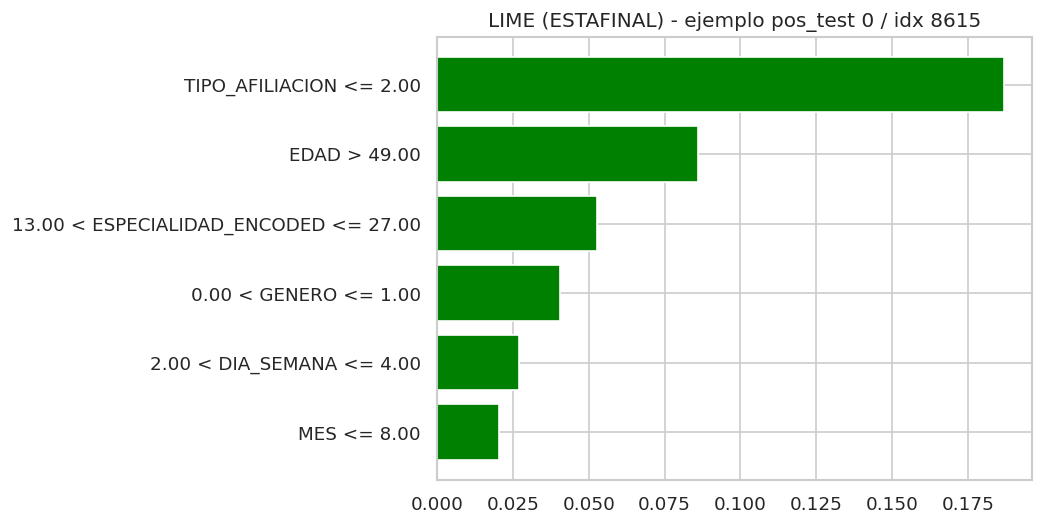

Grafico exportado: ../resultados/15_xai_lime_estafinal_ejemplo_pos_1.png


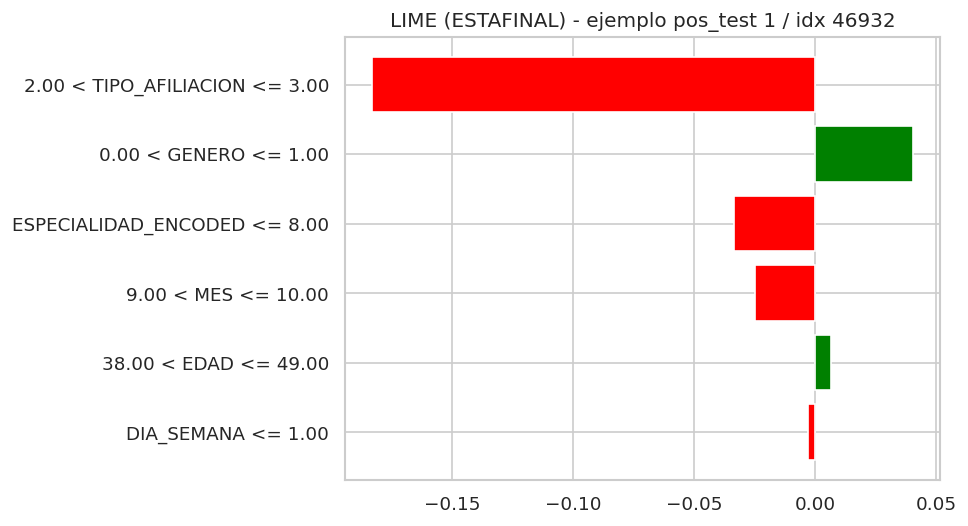

Top LIME (ejemplo de comparacion):
[('TIPO_AFILIACION <= 2.00', 0.18677287161172207), ('EDAD > 49.00', 0.08606106001366455), ('13.00 < ESPECIALIDAD_ENCODED <= 27.00', 0.05271516317779594), ('0.00 < GENERO <= 1.00', 0.04069417737448595), ('2.00 < DIA_SEMANA <= 4.00', 0.026909988927825285), ('MES <= 8.00', 0.020452404410655843)]


In [47]:
feature_names = X_train.columns.tolist()


def predict_fn_lime(x):
    # LIME entrega np.array; reconstruimos DataFrame para conservar nombres y evitar warnings
    x_df = pd.DataFrame(x, columns=feature_names)
    return model.predict_proba(x_df)


lime_explainer = LimeTabularExplainer(
    training_data=X_train.to_numpy(),
    feature_names=feature_names,
    class_names=[str(c) for c in model.classes_],
    mode='classification',
    discretize_continuous=True,
    random_state=RANDOM_STATE,
)

# Dos ejemplos concretos; el primero coincide con el ejemplo de comparacion SHAP/LIME (posicion 0)
lime_positions = [0, min(1, len(X_test) - 1)]
lime_explanations = []

for pos in lime_positions:
    exp = lime_explainer.explain_instance(
        data_row=X_test.iloc[pos].to_numpy(),
        predict_fn=predict_fn_lime,
        num_features=10,
    )
    lime_explanations.append(exp)

    fig = exp.as_pyplot_figure()
    plt.title(f'LIME (ESTAFINAL) - ejemplo pos_test {pos} / idx {X_test.index[pos]}')
    save_current_figure(f'xai_lime_estafinal_ejemplo_pos_{pos}', fig=fig)
    plt.show()
    plt.close(fig)

# Mantener visualizacion HTML en notebook (interactiva)
display(HTML(lime_explanations[0].as_html()))
print('Top LIME (ejemplo de comparacion):')
print(lime_explanations[0].as_list())

### Comparación visual entre SHAP y LIME para el mismo ejemplo individual

Grafico exportado: ../resultados/16_xai_comparacion_visual_shap_vs_lime_mismo_ejemplo.png


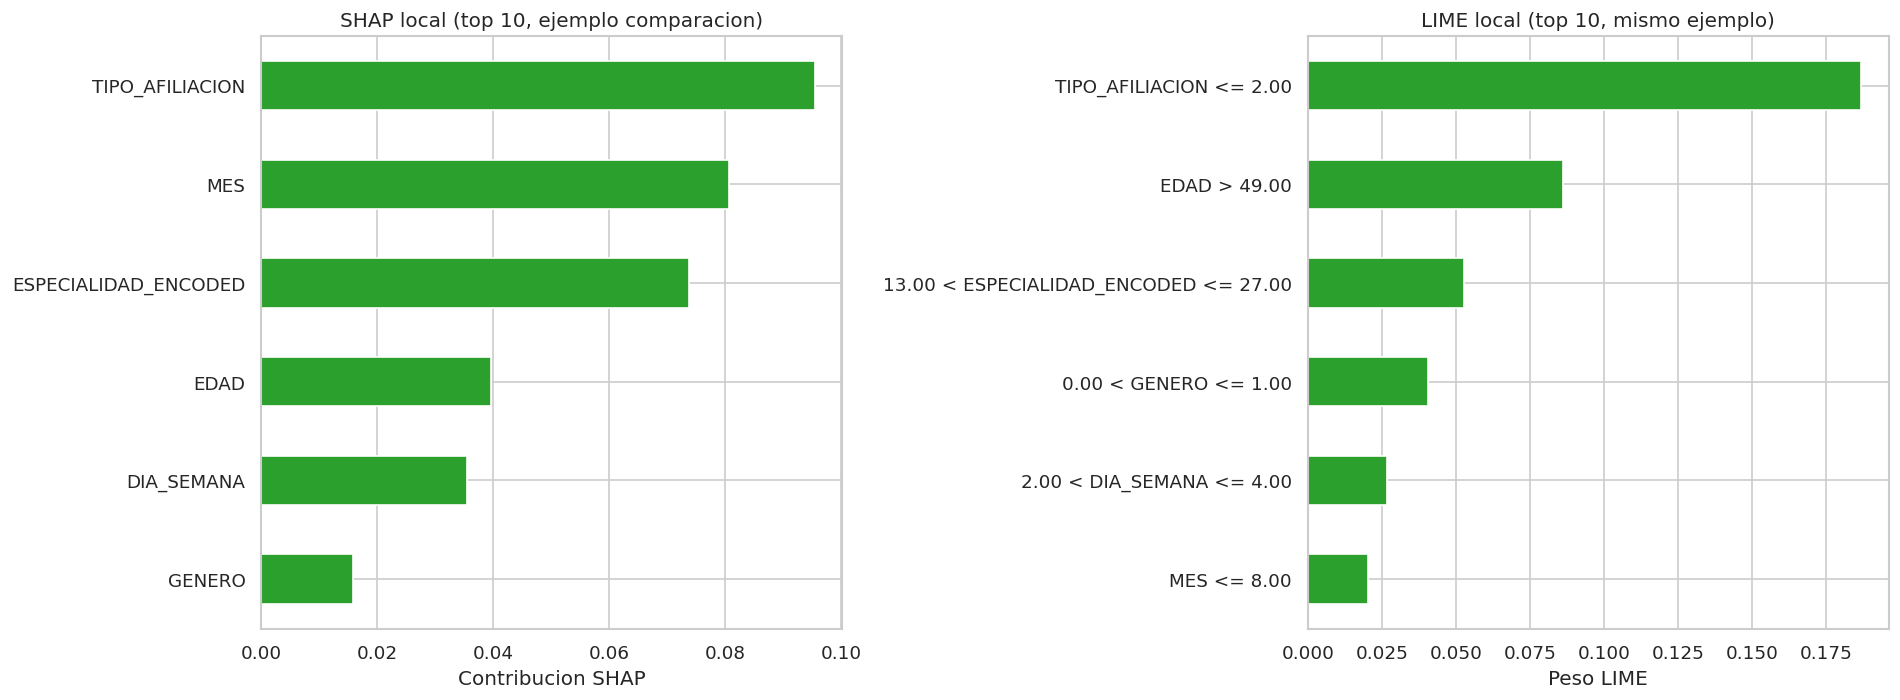

Comparacion top features SHAP vs LIME (mismo ejemplo):


,top_shap_local,top_lime_local
0,TIPO_AFILIACION,TIPO_AFILIACION
1,MES,EDAD
2,ESPECIALIDAD_ENCODED,ESPECIALIDAD_ENCODED
3,EDAD,GENERO
4,DIA_SEMANA,DIA_SEMANA


Solapamiento top-5: ['DIA_SEMANA', 'EDAD', 'ESPECIALIDAD_ENCODED', 'TIPO_AFILIACION']


In [48]:
lime_weights_raw = pd.Series(dict(lime_explanations[0].as_list()), dtype=float)
shap_local_signed = shap_local_ranked_example.copy()

# Subplot comparativo: SHAP local vs LIME local (mismo ejemplo)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

shap_plot_series = shap_local_signed.head(10).sort_values()
shap_plot_series.plot(kind='barh', ax=axes[0], color=['#2ca02c' if v >= 0 else '#d62728' for v in shap_plot_series])
axes[0].set_title('SHAP local (top 10, ejemplo comparacion)')
axes[0].set_xlabel('Contribucion SHAP')

lime_plot_series = lime_weights_raw.reindex(lime_weights_raw.abs().sort_values(ascending=False).index).head(10).sort_values()
lime_plot_series.plot(kind='barh', ax=axes[1], color=['#2ca02c' if v >= 0 else '#d62728' for v in lime_plot_series])
axes[1].set_title('LIME local (top 10, mismo ejemplo)')
axes[1].set_xlabel('Peso LIME')

plt.tight_layout()
save_current_figure('xai_comparacion_visual_shap_vs_lime_mismo_ejemplo', fig=fig)
plt.show()
plt.close(fig)

# Comparacion de solapamiento de variables (mapeando reglas LIME a nombre de feature)
def infer_lime_feature_name(rule_text, available_features):
    for feat in available_features:
        if feat in str(rule_text):
            return feat
    return str(rule_text)

lime_feature_agg = (
    pd.DataFrame({'rule': lime_weights_raw.index.astype(str), 'weight': lime_weights_raw.values})
    .assign(feature=lambda d: d['rule'].apply(lambda r: infer_lime_feature_name(r, feature_names)))
    .groupby('feature', as_index=True)['weight']
    .sum()
)

shap_top_features = list(shap_local_signed.abs().sort_values(ascending=False).head(5).index)
lime_top_features = list(lime_feature_agg.abs().sort_values(ascending=False).head(5).index)
top_overlap_features = sorted(set(shap_top_features) & set(lime_top_features))

comparison_overlap_df = pd.DataFrame({
    'top_shap_local': pd.Series(shap_top_features),
    'top_lime_local': pd.Series(lime_top_features),
})
print('Comparacion top features SHAP vs LIME (mismo ejemplo):')
display(comparison_overlap_df)
print('Solapamiento top-5:', top_overlap_features if top_overlap_features else 'Sin solapamiento directo (LIME usa reglas locales/intervalos)')

## 6. Detección de sesgos (auditoría por subgrupos)

Se calculan métricas por subgrupos para variables sensibles o sensibles/proxy (`GENERO`, `TIPO_AFILIACION`) y por grupos de edad, con el fin de evidenciar posibles disparidades del modelo base.


### Auditoria de sesgos: métricas por subgrupos (modelo base)


Metricas por subgrupo (GENERO) - modelo base:


,grupo_columna,grupo_valor,n,accuracy,f1_macro,balanced_accuracy
0,GENERO,MASCULINO,6803,0.632662,0.399177,0.396876
1,GENERO,FEMENINO,6727,0.562212,0.423829,0.421474


Grafico exportado: ../resultados/17_sesgo_metricas_subgrupos_genero_modelo_base.png


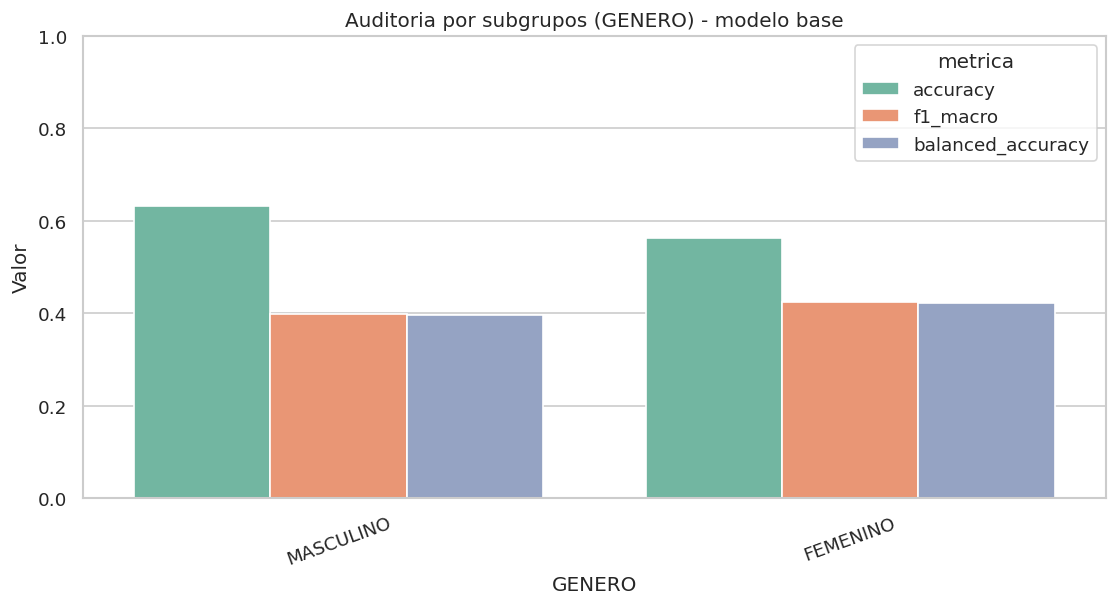


Metricas por subgrupo (TIPO_AFILIACION) - modelo base:


,grupo_columna,grupo_valor,n,accuracy,f1_macro,balanced_accuracy
0,TIPO_AFILIACION,SILVER,7265,0.673503,0.365653,0.369143
1,TIPO_AFILIACION,GOLD,5824,0.503262,0.422416,0.420842
2,TIPO_AFILIACION,CONVENIO,441,0.594104,0.383156,0.381967


Grafico exportado: ../resultados/18_sesgo_metricas_subgrupos_tipo_afiliacion_modelo_base.png


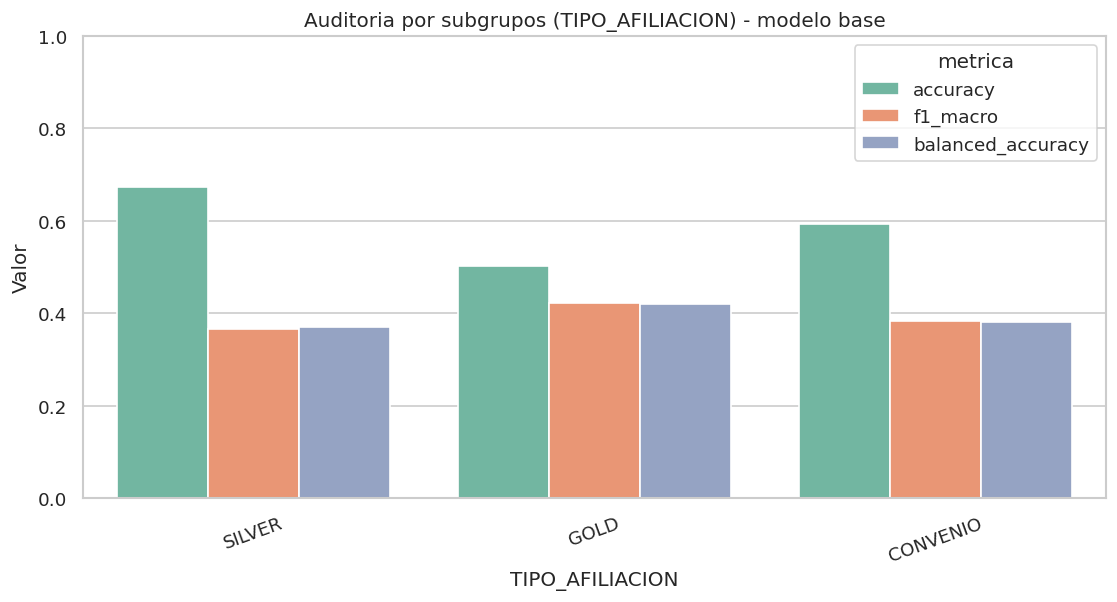


Metricas por subgrupo (EDAD_GRUPO) - modelo base:


,grupo_columna,grupo_valor,n,accuracy,f1_macro,balanced_accuracy
0,EDAD_GRUPO,30-44,4911,0.578294,0.401520,0.401615
1,EDAD_GRUPO,45-59,4181,0.647692,0.435381,0.428168
2,EDAD_GRUPO,18-29,2573,0.579479,0.401553,0.399158
3,EDAD_GRUPO,60+,939,0.628328,0.419811,0.412629
4,EDAD_GRUPO,0-17,926,0.493521,0.417923,0.417603


Grafico exportado: ../resultados/19_sesgo_metricas_subgrupos_edad_grupo_modelo_base.png


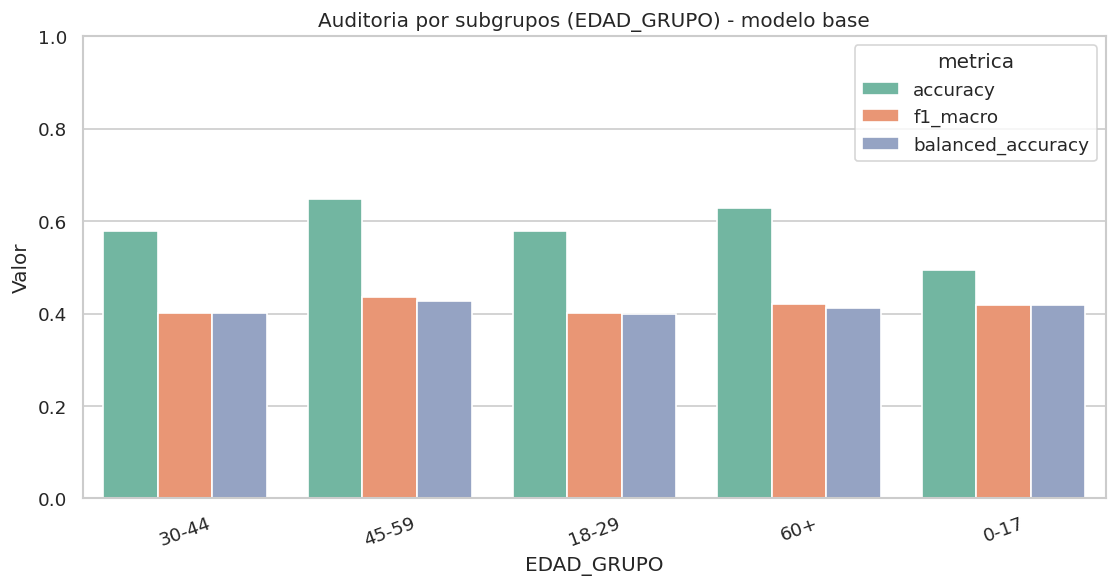


Resumen de brechas (max-min) por atributo - modelo base:


,atributo,gap_accuracy,gap_f1_macro,gap_balanced_accuracy
0,GENERO,0.070450,0.024653,0.024598
1,TIPO_AFILIACION,0.170241,0.056763,0.051699
2,EDAD_GRUPO,0.154171,0.033861,0.029010


Grafico exportado: ../resultados/20_sesgo_brechas_desempeno_por_atributo_modelo_base.png


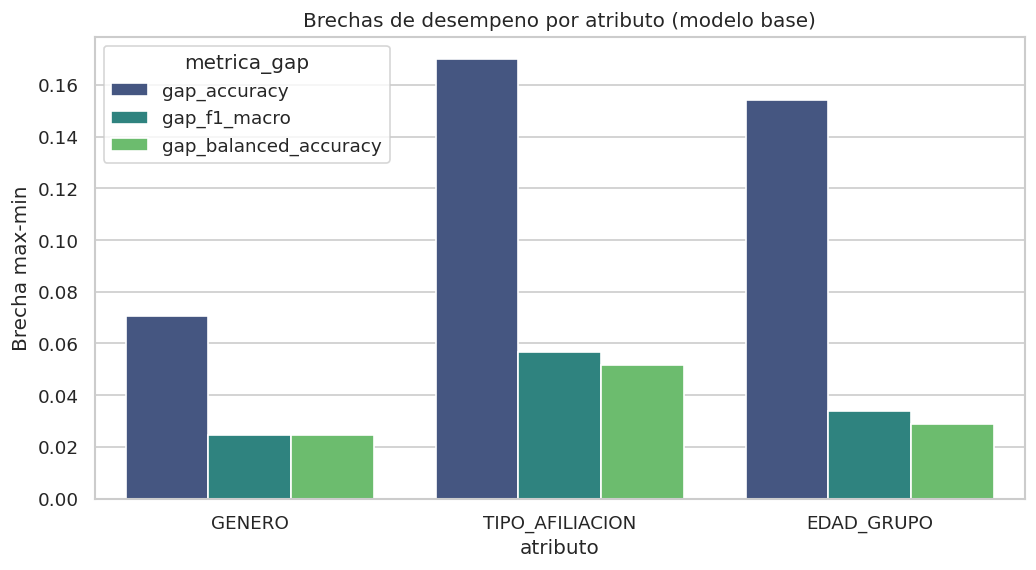

In [49]:
def add_age_group_column(eval_df):
    bins = [-np.inf, 17, 29, 44, 59, np.inf]
    labels = ['0-17', '18-29', '30-44', '45-59', '60+']
    out = eval_df.copy()
    out['EDAD_GRUPO'] = pd.cut(out['EDAD'], bins=bins, labels=labels)
    return out


def compute_group_metrics(eval_df, group_col, y_true_col='y_true', y_pred_col='y_pred'):
    rows = []
    for group_value, grp in eval_df.groupby(group_col, dropna=False):
        if len(grp) == 0:
            continue
        rows.append({
            'grupo_columna': group_col,
            'grupo_valor': str(group_value),
            'n': int(len(grp)),
            'accuracy': accuracy_score(grp[y_true_col], grp[y_pred_col]),
            'f1_macro': f1_score(grp[y_true_col], grp[y_pred_col], average='macro', zero_division=0),
            'balanced_accuracy': balanced_accuracy_score(grp[y_true_col], grp[y_pred_col]),
        })
    return pd.DataFrame(rows).sort_values(by='n', ascending=False).reset_index(drop=True)


def compute_gap_summary(group_metrics_dict):
    rows = []
    for attr, df_metric in group_metrics_dict.items():
        if df_metric.empty:
            continue
        rows.append({
            'atributo': attr,
            'gap_accuracy': df_metric['accuracy'].max() - df_metric['accuracy'].min(),
            'gap_f1_macro': df_metric['f1_macro'].max() - df_metric['f1_macro'].min(),
            'gap_balanced_accuracy': df_metric['balanced_accuracy'].max() - df_metric['balanced_accuracy'].min(),
        })
    return pd.DataFrame(rows)


def plot_group_metric_bars(df_metric, attribute_name, suffix_prefix):
    if df_metric.empty:
        return
    plot_df = df_metric.melt(
        id_vars=['grupo_valor', 'n'],
        value_vars=['accuracy', 'f1_macro', 'balanced_accuracy'],
        var_name='metrica',
        value_name='valor',
    )
    plt.figure(figsize=(11, 5))
    sns.barplot(data=plot_df, x='grupo_valor', y='valor', hue='metrica', palette='Set2')
    plt.ylim(0, 1)
    plt.title(f'Auditoria por subgrupos ({attribute_name}) - modelo base')
    plt.xlabel(attribute_name)
    plt.ylabel('Valor')
    plt.xticks(rotation=20)
    save_current_figure(f'{suffix_prefix}_{attribute_name.lower()}_modelo_base')
    plt.show()
    plt.close()


baseline_eval = test_context.copy()
baseline_eval['y_true'] = y_test
baseline_eval['y_pred'] = y_pred
baseline_eval = add_age_group_column(baseline_eval)

# Normalizamos etiquetas string para una mejor lectura de tablas/graficos
baseline_eval['GENERO'] = baseline_eval['GENERO'].astype(str).str.upper()
baseline_eval['TIPO_AFILIACION'] = baseline_eval['TIPO_AFILIACION'].astype(str).str.upper()

subgroup_metrics_base = {
    'GENERO': compute_group_metrics(baseline_eval, 'GENERO'),
    'TIPO_AFILIACION': compute_group_metrics(baseline_eval, 'TIPO_AFILIACION'),
    'EDAD_GRUPO': compute_group_metrics(baseline_eval, 'EDAD_GRUPO'),
}

for attr, df_metrics_attr in subgroup_metrics_base.items():
    print(f'\nMetricas por subgrupo ({attr}) - modelo base:')
    display(df_metrics_attr)
    plot_group_metric_bars(df_metrics_attr, attr, 'sesgo_metricas_subgrupos')

fairness_gap_baseline_df = compute_gap_summary(subgroup_metrics_base)
print('\nResumen de brechas (max-min) por atributo - modelo base:')
display(fairness_gap_baseline_df)

plt.figure(figsize=(10, 5))
gap_plot_base = fairness_gap_baseline_df.melt(id_vars='atributo', var_name='metrica_gap', value_name='brecha')
sns.barplot(data=gap_plot_base, x='atributo', y='brecha', hue='metrica_gap', palette='viridis')
plt.title('Brechas de desempeno por atributo (modelo base)')
plt.ylabel('Brecha max-min')
save_current_figure('sesgo_brechas_desempeno_por_atributo_modelo_base')
plt.show()
plt.close()

### Mitigación de sesgos (estrategia simple): excluir variables sensibles + class_weight balanceado

Nota: no elimina proxies completamente, pero permite comparar trade-offs de equidad y desempeño.

Features modelo mitigado (sin variables sensibles directas): ['EDAD', 'ESPECIALIDAD_ENCODED', 'MES', 'DIA_SEMANA']


Entrenamiento modelo mitigado (RF):   0%|          | 0/200 [00:00<?, ?it/s]

Comparacion global de metricas (base vs mitigado):


,modelo,accuracy,f1_macro,balanced_accuracy
0,base,0.597635,0.415984,0.412809
1,mitigado_sin_sensibles_balanceado,0.483222,0.402279,0.412496



Comparacion de brechas por atributo (base vs mitigado):


,atributo,gap_accuracy_base,gap_f1_macro_base,gap_balanced_accuracy_base,gap_accuracy_mitigado,gap_f1_macro_mitigado,gap_balanced_accuracy_mitigado
0,GENERO,0.070450,0.024653,0.024598,0.010241,0.018219,0.008948
1,TIPO_AFILIACION,0.170241,0.056763,0.051699,0.063486,0.039216,0.035064
2,EDAD_GRUPO,0.154171,0.033861,0.029010,0.151529,0.050874,0.033455


Grafico exportado: ../resultados/21_sesgo_mitigacion_comparacion_metricas_globales.png


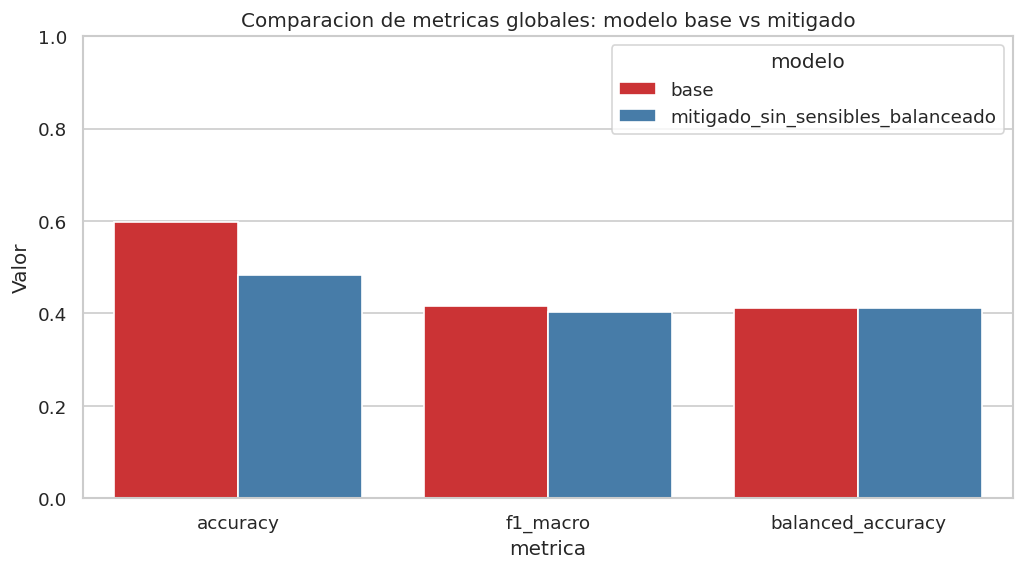

Grafico exportado: ../resultados/22_sesgo_mitigacion_comparacion_brechas_por_atributo.png


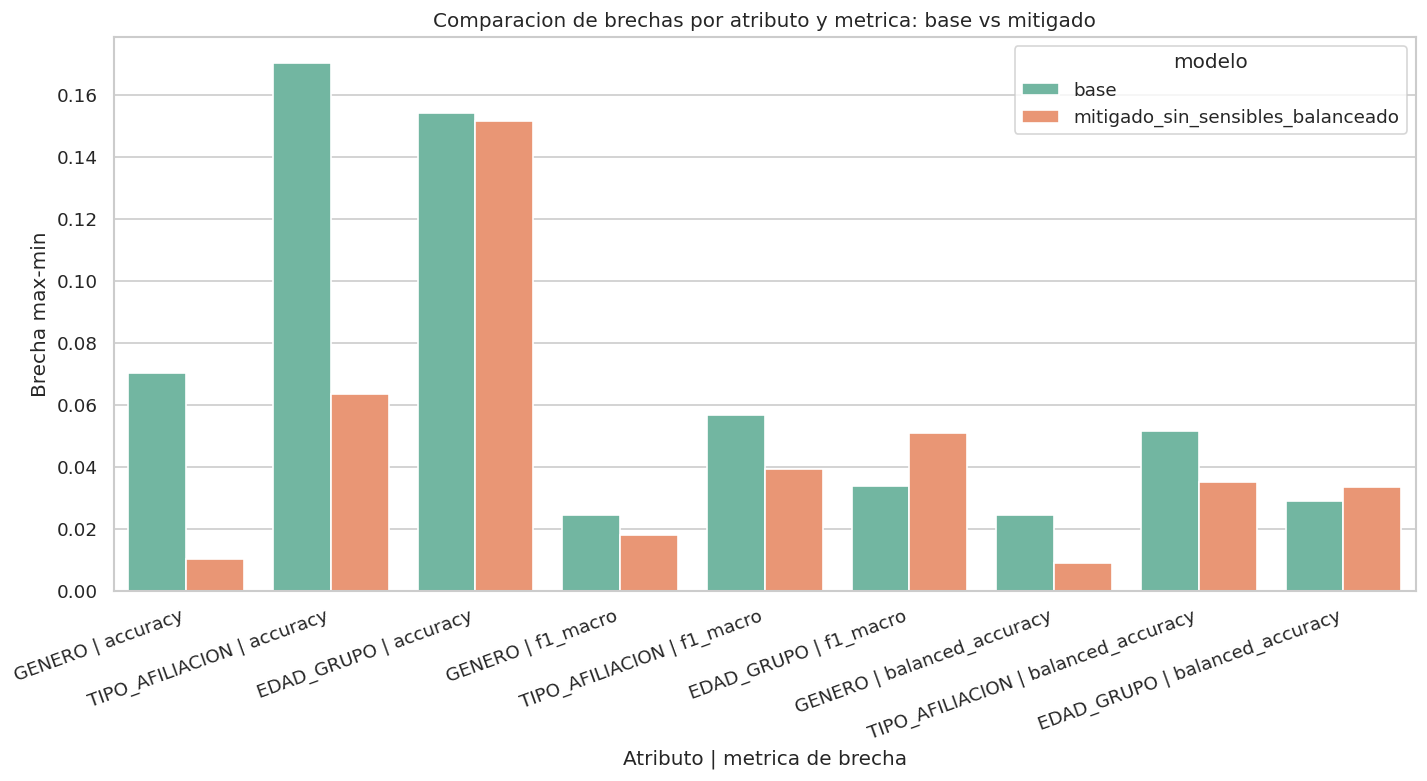

Grafico exportado: ../resultados/23_sesgo_mitigacion_macro_f1_por_genero.png


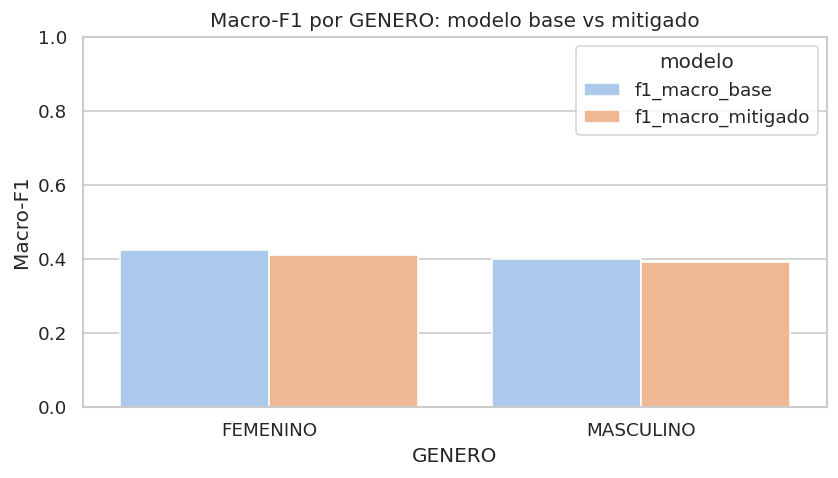

In [50]:
mitigation_features = [f for f in features if f not in sensitive_features]
print('Features modelo mitigado (sin variables sensibles directas):', mitigation_features)

model_mitigated = fit_random_forest_with_progress(
    X_train[mitigation_features],
    y_train,
    n_estimators=200,
    desc='Entrenamiento modelo mitigado (RF)',
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1,
)

y_pred_mitigated = model_mitigated.predict(X_test[mitigation_features])
y_pred_proba_mitigated = model_mitigated.predict_proba(X_test[mitigation_features])

mitigated_metrics = {
    'accuracy': accuracy_score(y_test, y_pred_mitigated),
    'f1_macro': f1_score(y_test, y_pred_mitigated, average='macro', zero_division=0),
    'balanced_accuracy': balanced_accuracy_score(y_test, y_pred_mitigated),
}

overall_comparison_df = pd.DataFrame([
    {'modelo': 'base', **baseline_metrics},
    {'modelo': 'mitigado_sin_sensibles_balanceado', **mitigated_metrics},
])
print('Comparacion global de metricas (base vs mitigado):')
display(overall_comparison_df)

# Auditoria por subgrupos del modelo mitigado sobre el mismo conjunto de test
mitigated_eval = test_context.copy()
mitigated_eval['y_true'] = y_test
mitigated_eval['y_pred'] = y_pred_mitigated
mitigated_eval = add_age_group_column(mitigated_eval)
mitigated_eval['GENERO'] = mitigated_eval['GENERO'].astype(str).str.upper()
mitigated_eval['TIPO_AFILIACION'] = mitigated_eval['TIPO_AFILIACION'].astype(str).str.upper()

subgroup_metrics_mitigated = {
    'GENERO': compute_group_metrics(mitigated_eval, 'GENERO'),
    'TIPO_AFILIACION': compute_group_metrics(mitigated_eval, 'TIPO_AFILIACION'),
    'EDAD_GRUPO': compute_group_metrics(mitigated_eval, 'EDAD_GRUPO'),
}

fairness_gap_mitigated_df = compute_gap_summary(subgroup_metrics_mitigated)

# Comparacion de brechas base vs mitigado
group_gap_comparison_df = fairness_gap_baseline_df.merge(
    fairness_gap_mitigated_df,
    on='atributo',
    suffixes=('_base', '_mitigado'),
)
print('\nComparacion de brechas por atributo (base vs mitigado):')
display(group_gap_comparison_df)

# Grafico: metricas globales base vs mitigado
overall_cmp_plot = overall_comparison_df.melt(id_vars='modelo', var_name='metrica', value_name='valor')
plt.figure(figsize=(10, 5))
sns.barplot(data=overall_cmp_plot, x='metrica', y='valor', hue='modelo', palette='Set1')
plt.ylim(0, 1)
plt.title('Comparacion de metricas globales: modelo base vs mitigado')
plt.ylabel('Valor')
save_current_figure('sesgo_mitigacion_comparacion_metricas_globales')
plt.show()
plt.close()

# Grafico: brechas de desempeno por atributo base vs mitigado
gap_compare_plot = pd.concat([
    fairness_gap_baseline_df.assign(modelo='base'),
    fairness_gap_mitigated_df.assign(modelo='mitigado_sin_sensibles_balanceado'),
], ignore_index=True)
gap_compare_plot = gap_compare_plot.melt(id_vars=['atributo', 'modelo'], var_name='metrica_gap', value_name='brecha')
gap_compare_plot['atributo_metrica'] = gap_compare_plot['atributo'] + ' | ' + gap_compare_plot['metrica_gap'].str.replace('gap_', '', regex=False)
plt.figure(figsize=(14, 6))
sns.barplot(data=gap_compare_plot, x='atributo_metrica', y='brecha', hue='modelo', palette='Set2')
plt.title('Comparacion de brechas por atributo y metrica: base vs mitigado')
plt.xlabel('Atributo | metrica de brecha')
plt.ylabel('Brecha max-min')
plt.xticks(rotation=20, ha='right')
save_current_figure('sesgo_mitigacion_comparacion_brechas_por_atributo')
plt.show()
plt.close()

# Una visualizacion adicional por subgrupo sensible (GENERO) para macro-F1
comp_genero = subgroup_metrics_base['GENERO'][['grupo_valor', 'f1_macro']].rename(columns={'f1_macro': 'f1_macro_base'})
comp_genero = comp_genero.merge(
    subgroup_metrics_mitigated['GENERO'][['grupo_valor', 'f1_macro']].rename(columns={'f1_macro': 'f1_macro_mitigado'}),
    on='grupo_valor',
    how='outer',
)
comp_genero_plot = comp_genero.melt(id_vars='grupo_valor', var_name='modelo', value_name='f1_macro')
plt.figure(figsize=(8, 4))
sns.barplot(data=comp_genero_plot, x='grupo_valor', y='f1_macro', hue='modelo', palette='pastel')
plt.ylim(0, 1)
plt.title('Macro-F1 por GENERO: modelo base vs mitigado')
plt.xlabel('GENERO')
plt.ylabel('Macro-F1')
save_current_figure('sesgo_mitigacion_macro_f1_por_genero')
plt.show()
plt.close()

## 7. Analisis interpretativo y reflexivo

#### 1. Alcance del entrenamiento y partición de datos
- El modelo **no** se entrena con una muestra pequena: se entrena con **todo `X_train`** (split de entrenamiento).
- `X_test` se reserva para evaluación final (holdout), por lo que **no** se usa para ajustar el modelo.
- La validación cruzada (5-fold) recorre el dataset completo por pliegues para estimar estabilidad.
- La única reducción por muestreo aplica a **SHAP** para visualización: muestra configurable de `X_test` (efectiva: 300/13530). Esto **no** afecta el entrenamiento.

#### 2. Desempeño del modelo base (holdout)
- Accuracy: **59.76%**
- F1 macro: **41.60%**
- Balanced accuracy: **41.28%**
- Soporte visual complementario: matriz de confusión, curvas ROC multiclase y gráafico de métricas holdout.

#### 3. Estabilidad del modelo (validación cruzada 5-fold)
- Accuracy promedio +- desviación: **60.06% +- 0.27%**
- F1 macro promedio +- desviación: **41.79% +- 0.38%**
- Balanced accuracy promedio +- desviación: **41.44% +- 0.31%**
- Interpretación: la validación cruzada complementa el holdout y permite verificar consistencia entre pliegues.

#### 4. Explicabilidad (SHAP y LIME)
- Variables mas influyentes segun **SHAP global** (top 5): **ESPECIALIDAD_ENCODED, TIPO_AFILIACION, EDAD, MES, DIA_SEMANA**.
- En el ejemplo local de SHAP, la interpretacion se hace sobre la **clase predicha por el modelo** para ese registro (no sobre una clase seleccionada manualmente).
- Reglas/atributos mas relevantes del ejemplo local en **LIME** (top 5):
- `TIPO_AFILIACION <= 2.00`
- `EDAD > 49.00`
- `13.00 < ESPECIALIDAD_ENCODED <= 27.00`
- `0.00 < GENERO <= 1.00`
- `2.00 < DIA_SEMANA <= 4.00`

- Reflexion concreta: tanto SHAP como LIME vuelven a resaltar **TIPO_AFILIACION**, **EDAD** y **ESPECIALIDAD_ENCODED** (en SHAP como variables globales; en LIME como reglas locales del ejemplo), lo que sugiere que estas variables estructuran una parte importante de la decision del modelo.
- La comparacion SHAP vs LIME permite contrastar coherencia entre contribuciones globales/locales y reglas locales aproximadas.
#### 5. Auditoría de sesgos 
- Brecha por `GENERO` (max-min entre subgrupos): **accuracy=7.05%, f1_macro=2.47%, balanced_accuracy=2.46%**
- Brecha por `TIPO_AFILIACION` (max-min entre subgrupos): **accuracy=17.02%, f1_macro=5.68%, balanced_accuracy=5.17%**
- Brecha por `EDAD_GRUPO` (max-min entre subgrupos): **accuracy=15.42%, f1_macro=3.39%, balanced_accuracy=2.90%**

#### 6. Mitigación y trade-off (base vs mitigado)
- Comparación global de métricas:
- **base**: accuracy=59.76%, f1_macro=41.60%, balanced_accuracy=41.28%
- **mitigado_sin_sensibles_balanceado**: accuracy=48.32%, f1_macro=40.23%, balanced_accuracy=41.25%
- Cambio en brechas por `GENERO` (base -> mitigado): **accuracy 7.05% -> 1.02%; f1_macro 2.47% -> 1.82%; balanced_accuracy 2.46% -> 0.89%**
- Cambio en brechas por `TIPO_AFILIACION` (base -> mitigado): **accuracy 17.02% -> 6.35%; f1_macro 5.68% -> 3.92%; balanced_accuracy 5.17% -> 3.51%**
- Cambio en brechas por `EDAD_GRUPO` (base -> mitigado): **accuracy 15.42% -> 15.15%; f1_macro 3.39% -> 5.09%; balanced_accuracy 2.90% -> 3.35%**
- Interpretación: la mitigacion debe evaluarse por su efecto conjunto en rendimiento global y equidad por subgrupos.

### Transparencia, riesgos éticos y reflexiones (IA responsable)

#### Transparencia del modelo  
La transparencia técnica del modelo es **moderada**. Hemos logrado explicar decisiones locales utilizando técnicas XAI, especialmente **LIME**, donde se observa cómo la predicción se descompone en factores comprensibles para personas no técnicas. Por ejemplo, el modelo asigna pesos a condiciones interpretables como rangos de edad, temporalidad (mes y día de la semana), especialidad y tipo de afiliación, y con ello construye una probabilidad final asociada al estado de la cita. En términos prácticos, esto nos permite justificar por qué el sistema estima mayor probabilidad de un resultado final específico y qué variables empujan esa conclusión.

#### Riesgos éticos y sociales si se implementa el sistema  
Durante el análisis identificamos **tres riesgos principales**:

1. **Sesgo asociado al tipo de afiliación.**  
   El modelo puede aprender y perpetuar desigualdades vinculadas a condiciones socioeconómicas si `TIPO_AFILIACION` actúa como un proxy. Cuando esta variable aparece como explicativa relevante, existe el riesgo de que el sistema termine priorizando o penalizando grupos según su afiliación, afectando la equidad en la atención.

2. **Discriminación indirecta por edad o género.**  
   El análisis exploratorio muestra distribuciones diferentes por grupos. Si el modelo aprende correlaciones espurias —por ejemplo, asociar incumplimiento a ciertos rangos de edad o a un género— podría generar decisiones injustas, incluso cuando no exista una relación causal real.

3. **Deshumanización de la toma de decisiones.**  
   Automatizar la gestión de citas solo por probabilidad de asistencia sin considerar factores externos (transporte, emergencias, barreras del sistema) podría traducirse en decisiones rígidas que reduzcan el acceso o generen fricción con pacientes.

#### Consideraciones para mejorar el modelo  
Para elevar la utilidad del sistema y reducir riesgos, proponemos **tres líneas concretas**:

- **Incorporar variables externas relevantes** (si están disponibles y con consentimiento), como distancia/ubicación, congestión/tráfico o clima, que pueden explicar incumplimiento mejor que proxies sensibles.  
- **Controlar el desbalance de clases** y asegurar representatividad, ya que el modelo puede sesgarse hacia la clase mayoritaria si no se evalúa con métricas robustas (F1 macro, balanced accuracy).  
- **Monitorear el modelo** con auditoría continua, evaluando desempeño por subgrupos y revisando cambios de distribución para detectar degradación o nuevas brechas de equidad.

#### Reflexión sobre el proceso  
En este trabajo aprendimos que el modelo **no toma decisiones lineales**, sino que combina múltiples señales al mismo tiempo, y que la explicabilidad local ayuda a traducir esa combinación a razones entendibles. También observamos que algunas variables pueden adquirir un peso elevado; en particular, `ESPECIALIDAD` y `TIPO_AFILIACION` tienden a influir significativamente en la predicción, lo cual exige interpretación cuidadosa para evitar conclusiones injustas. Si este sistema se implementara **sin explicabilidad**, se perdería confianza y control: el personal no podría justificar decisiones, sería más difícil corregir errores y el modelo podría amplificar sesgos sin que el equipo detecte qué variables los generan. En consecuencia, la explicabilidad no es un adorno, sino un mecanismo de gobernanza del modelo y una base para decisiones responsables.